# This notebook preprocesses the raw data
### from quality control to creating a clean aggregate data set

Input: raw data in the raw_data folder

Output: clean data in csv form in processed_data folder

Imports

In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
from scipy.io import loadmat
import pickle as pkl

Set global variables and propertes

In [2]:
raw_data_fname_str = ""
raw_data_folder = "raw_data"

results_folder = "results"

processed_data_folder = "processed_data"

pooled_data_fname = "pooled_data.csv"
pooled_data_file = os.path.join(processed_data_folder, pooled_data_fname)

summary_data_fname = "summary_data.csv"
summary_data_file = os.path.join(processed_data_folder, summary_data_fname)

full_data_fname = "full_data.csv"
full_data_file = os.path.join(processed_data_folder, full_data_fname)

mask_file_name = "mask.txt"
mask_file = os.path.join(processed_data_folder, mask_file_name)

statistics_folder = os.path.join(results_folder, "statistics")

In [3]:
trials =  201#number of trials
T = 3 #number of time steps in each trial
nb = 4 # number of bandits, ie second level rewards
ns = 3+nb #number of states
no = ns #number of observations
na = 2 #number of actions
npi = na**(T-1) #number of policies
nr = 2 #number of rewards
never_reward = ns-nb # states that dont generate rewards

# make global parameter dict:
global_experiment_parameters = {"trials": trials, "T": T, "nb": nb, "ns": ns, "no": no, "na": na, "npi": npi, "nr": nr, "never_reward": never_reward}

True second stage random walks from the experiment

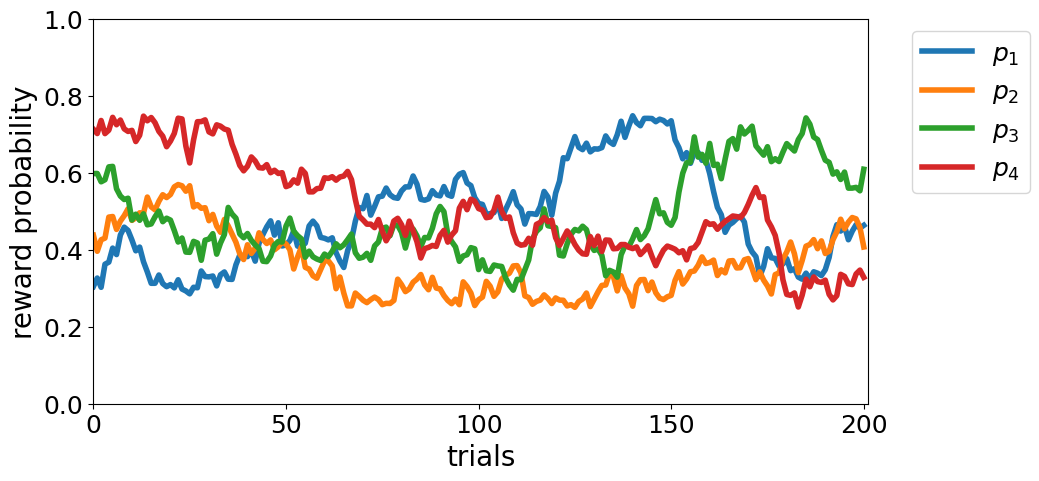

In [4]:
Rho_data_fname = os.path.join("experiment", "dawrandomwalks.mat")

rew_probs = loadmat(Rho_data_fname)['dawrandomwalks']
assert trials==rew_probs.shape[-1]

Rho = np.zeros((trials, nr, ns))

Rho[:,1,:never_reward] = 0.
Rho[:,0,:never_reward] = 1.

Rho[:,1,never_reward:never_reward+2] = (rew_probs[0,:,:]).transpose((1,0))
Rho[:,0,never_reward:never_reward+2] = (1-rew_probs[0,:,:]).transpose((1,0))

Rho[:,1,never_reward+2:] = (rew_probs[1,:,:]).transpose((1,0))
Rho[:,0,never_reward+2:] = (1-rew_probs[1,:,:]).transpose((1,0))

plt.figure(figsize=(10,5))
for i in range(4):
    plt.plot(Rho[:,1,3+i], label="$p_{}$".format(i+1), linewidth=4)
plt.ylim([0,1])
plt.yticks(np.arange(0,1.1,0.2),fontsize=18)
plt.ylabel("reward probability", fontsize=20)
plt.xlim([-0.1, trials+0.1])
plt.xticks(range(0,trials+1,50),fontsize=18)
plt.xlabel("trials", fontsize=20)
plt.legend(fontsize=18, bbox_to_anchor=(1.04,1))
plt.savefig(os.path.join(statistics_folder, "twostep_prob.svg"),dpi=300)
plt.show()

# add to parameter dict
global_experiment_parameters["Rho"] = Rho

Create test data frame

In [5]:
processed_data = pd.DataFrame({"subject": [], "trial": [], "valid": [], 
                               "choices first stage": [], "choices second stage": [], 
                               "RTs first stage": [], "RTs second stage": [], 
                               "states first stage": [], "states second stage": [], 
                               "outcomes first stage": [], "outcomes second stage": []})

In [6]:
def load_dataset(fname, rew_probs):
    dataset = loadmat(fname)
    np.testing.assert_allclose(dataset['dawrandomwalks'], rew_probs, err_msg='This person has different reward probabilities')

    actions = dataset['A'].transpose(1,0)#.astype(np.int32)
    nan_mask = np.isnan(actions)
    # question: what is the difference between action==0 and nan?
    invalid_mask = np.logical_or(nan_mask,actions==0)
    mask = np.logical_not(np.any(invalid_mask, axis=1))
    first_stage_actions = actions[:,0]#np.where(mask, actions[:,0], np.nan)
    second_stage_actions = actions[:,1]#np.where(mask, actions[:,1], np.nan)
    #print("possible actions1", np.unique(first_stage_actions[mask]))
    #print("possible actions2", np.unique(second_stage_actions[mask]))

    repeated_actions = first_stage_actions[:trials-1] == first_stage_actions[1:]
    repeated_actions = np.append(repeated_actions, [False])

    first_stage_rewards = np.zeros(trials).astype(int)
    second_stage_rewards = dataset['R'][0].astype(int)

    #print("possible rewards1", np.unique(first_stage_rewards))
    #print("possible rewards2", np.unique(second_stage_rewards))

    first_stage_states = dataset['S'][0].astype(int)
    second_stage_states = dataset['S'][1].astype(int)

    #print("possible states1", np.unique(first_stage_states[mask]))
    #print("possible states2", np.unique(second_stage_states[mask]))

    #first_stage_index = np.array([True]*trials + [False]*trials)
    #second_stage_index = np.array([False]*trials + [True]*trials)

    miniblock_index = np.array(list(range(trials)) + list(range(trials)))
    step_index = np.array([1]*trials + [2]*trials)

    formatted_first_stage_actions = np.append(first_stage_actions, np.zeros(trials)-1)
    formatted_second_stage_actions = np.append(np.zeros(trials)-1, second_stage_actions)

    # attention, this will code for whether the action at this index is repeated in the next
    formatted_repeated_actions = np.append(repeated_actions, repeated_actions)

    formatted_first_stage_rewards = np.append(first_stage_rewards, np.zeros(trials)-1)
    formatted_second_stage_rewards = np.append(np.zeros(trials)-1, second_stage_rewards)

    formatted_rewarded = formatted_second_stage_rewards>0

    formatted_first_stage_states = np.append(first_stage_states, np.zeros(trials)-1)
    formatted_second_stage_states = np.append(np.zeros(trials)-1, second_stage_states)

    common_transition = np.append(dataset['trans'][0], dataset['trans'][0])

    formatted_mask = np.append(mask, mask)

    data_dict = {"first_stage_actions": formatted_first_stage_actions, "second_stage_actions": formatted_second_stage_actions,
                 "first_stage_rewards": formatted_first_stage_rewards, "second_stage_rewards": formatted_second_stage_rewards,
                 "first_stage_states": formatted_first_stage_states, "second_stage_states": formatted_second_stage_states,
                 #"first_stage_index": first_stage_index, "second_stage_index": second_stage_index,
                 "miniblock_index": miniblock_index, "step_index": step_index,
                 "common_transition": common_transition, "mask": formatted_mask,
                 "repeated_actions": formatted_repeated_actions, "rewarded": formatted_rewarded
                 }
    
    data_df = pd.DataFrame(data_dict)


    return data_df, dataset, mask

In [7]:
dataset_names = os.listdir(raw_data_folder)

# dataset number 117 is unfortunately not readable
del dataset_names[117]

nsubs = len(dataset_names)
print(nsubs)

188


/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


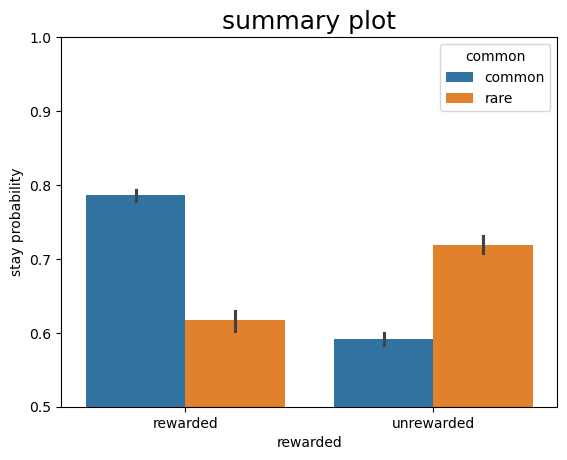

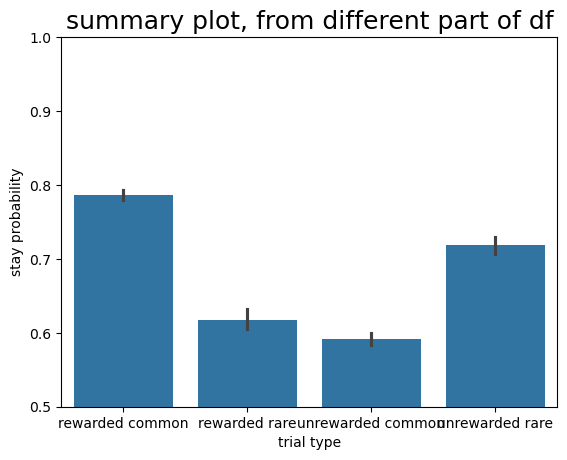

/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/hom

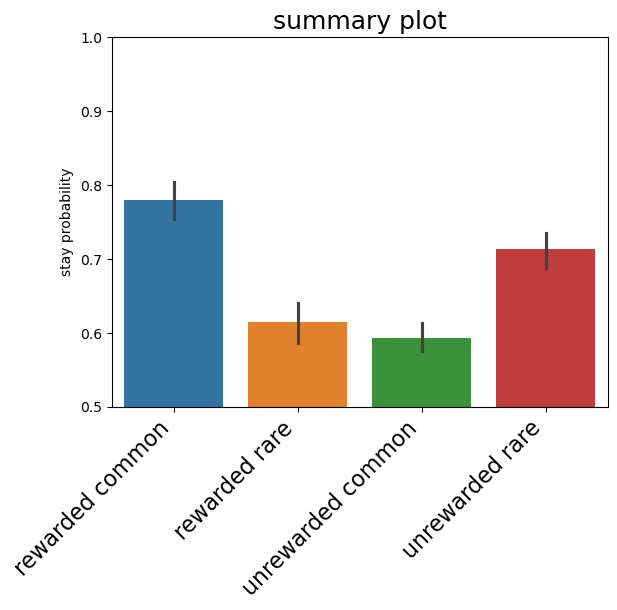

In [8]:
data = []
stayed = []
indices = []

summary_data = []
pooled_data = []
all_mask = []

for i in range(nsubs):#

    fname = os.path.join(raw_data_folder, dataset_names[i])
    data_df, dataset, mask = load_dataset(fname, rew_probs)

    all_mask.append(list(mask))

    data_df['subject'] = [i]*len(data_df)

    data.append(data_df)

    smaller_df = data_df.loc[(data_df["step_index"]==2) & (data_df["miniblock_index"]<trials-1) & data_df["mask"]]

    rewarded = smaller_df['rewarded'] > 0
    #print(rewarded)
    rewarded_names = ["unrewarded", "rewarded"]
    rewarded_keys = [rewarded_names[int(i)] for i in rewarded]

    rewarded2 = smaller_df["second_stage_rewards"]>0

    np.testing.assert_allclose(rewarded, rewarded2)

    unrewarded = rewarded==False#w.rewards[:trials-1,-1] == 0

    common = smaller_df["common_transition"] > 0
    #print(common)

    common_names = ["rare", "common"]
    common_keys = [common_names[int(i)] for i in common]

    rare = common == False

    names = ["rewarded common", "rewarded rare", "unrewarded common", "unrewarded rare"]

    # index_list = [np.intersect1d(rewarded, common), np.intersect1d(rewarded, rare),
    #              np.intersect1d(unrewarded, common), np.intersect1d(unrewarded, rare)]

    rewarded_common = np.logical_and(rewarded,common)
    rewarded_rare = np.logical_and(rewarded,rare)
    unrewarded_common = np.logical_and(unrewarded,common)
    unrewarded_rare = np.logical_and(unrewarded,rare)

    index_list = [rewarded_common, rewarded_rare,
                 unrewarded_common, unrewarded_rare]
    
    index_keys = rewarded_common*0+rewarded_rare*1+unrewarded_common*2+unrewarded_rare*3

    keys = [names[key] for key in index_keys]

    subject_arr = np.zeros(len(smaller_df))+i

    subject_dict = {"trial type": keys, "subject": subject_arr,
                            "rewarded": rewarded_keys, "common": common_keys,
                            "repeat": smaller_df["repeated_actions"]}
    
    subject_df = pd.DataFrame(subject_dict)
    
    pooled_data.append(subject_df)

    subject_summary_dict = {"subject": [i], 
                    "rewarded common": [smaller_df[rewarded_common]["repeated_actions"].mean()],
                    "rewarded rare": [smaller_df[rewarded_rare]["repeated_actions"].mean()],
                    "unrewarded common": [smaller_df[unrewarded_common]["repeated_actions"].mean()],
                    "unrewarded rare": [smaller_df[unrewarded_rare]["repeated_actions"].mean()],}
    
    subject_summary_df = pd.DataFrame(subject_summary_dict)
    
    summary_data.append(subject_summary_df)

pooled_data_df = pd.concat(pooled_data)

#print(pooled_data_df)

full_data_df = pd.concat(data)

#mask_array = np.stack(all_mask, axis=-1).astype(int)
#print(mask_array)
#np.savetxt(mask_file, mask_array, fmt="%5i", delimiter=',')
with open(mask_file, "wb") as f:
    pkl.dump(all_mask, f)

plt.figure()
g = sns.barplot(data=pooled_data_df, x="rewarded", y="repeat", hue="common", order=["rewarded", "unrewarded"])
#g.set_xticklabels(names, rotation=45, horizontalalignment='right', fontsize=16)
plt.ylim([0.5,1])
# plt.yticks(np.arange(0,1.1,0.2),fontsize=16)
plt.title("summary plot", fontsize=18)
plt.savefig(os.path.join(statistics_folder, "behavior_summary_plot_df.svg"),dpi=300)
plt.ylabel("stay probability")
plt.show()

plt.figure()
g = sns.barplot(data=pooled_data_df, x="trial type", y="repeat", order=names)
#g.set_xticklabels(names, rotation=45, horizontalalignment='right', fontsize=16)
plt.ylim([0.5,1])
# plt.yticks(np.arange(0,1.1,0.2),fontsize=16)
plt.title("summary plot, from different part of df", fontsize=18)
#plt.savefig("behavior_summary_plot.svg",dpi=300)
plt.ylabel("stay probability")
plt.show()


summary_df = pd.concat(summary_data)
summary_stayed_arr = [summary_df["rewarded common"], summary_df["rewarded rare"], summary_df["unrewarded common"], summary_df["unrewarded rare"]]

plt.figure()
g = sns.barplot(data=summary_stayed_arr)
g.set_xticklabels(names, rotation=45, horizontalalignment='right', fontsize=16)
plt.ylim([0.5,1])
# plt.yticks(np.arange(0,1.1,0.2),fontsize=16)
plt.title("summary plot", fontsize=18)
plt.savefig(os.path.join(statistics_folder, "behavior_summary_plot.svg"),dpi=300)
plt.ylabel("stay probability")
plt.show()

/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


/home/sarah/anaconda3/envs/two_stage/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


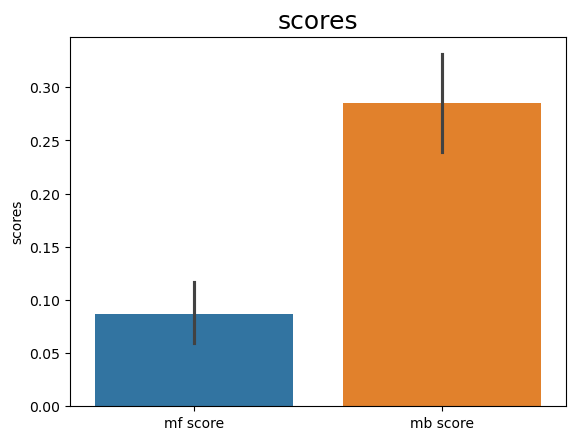

<Figure size 640x480 with 0 Axes>

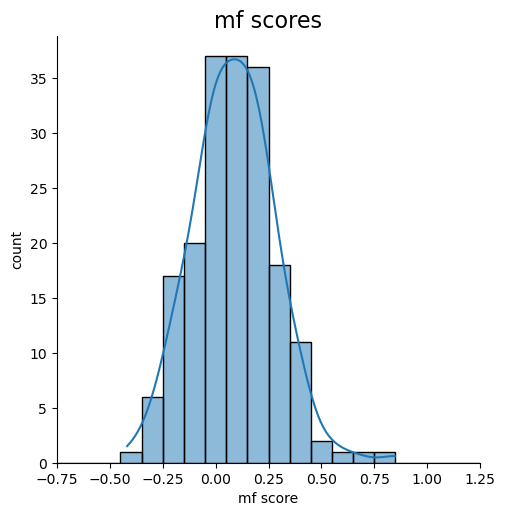

<Figure size 640x480 with 0 Axes>

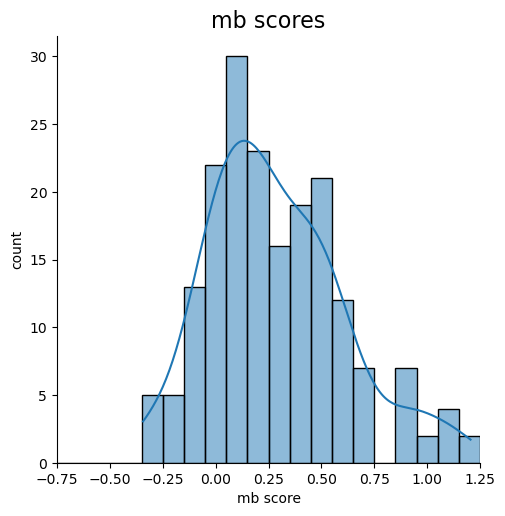

In [9]:
mf_score = summary_stayed_arr[0] + summary_stayed_arr[1] - summary_stayed_arr[2] - summary_stayed_arr[3]

mb_score = summary_stayed_arr[0] - summary_stayed_arr[1] - summary_stayed_arr[2] + summary_stayed_arr[3]

scores = pd.DataFrame({'mf score': mf_score, 'mb score': mb_score})

plt.figure()
g = sns.barplot(data=scores)
#plt.ylim([0,0.5])
# plt.yticks(np.arange(0,1.1,0.2),fontsize=16)
plt.title("scores", fontsize=18)
plt.savefig(os.path.join(statistics_folder, "behavior_scores.svg"),dpi=300)
plt.ylabel("scores")
plt.show()

plt.figure()
sns.displot(data=scores, x="mf score", kde=True, binrange=[-0.75,1.25], bins=20)
plt.xlim([-0.75,1.25])
#plt.ylim([0,0.5])
# plt.yticks(np.arange(0,1.1,0.2),fontsize=16)
plt.title("mf scores", fontsize=16)
plt.savefig(os.path.join(statistics_folder, "mf_scores.svg"),dpi=300)
plt.ylabel("count")
plt.show()

plt.figure()
sns.displot(data=scores, x="mb score", kde=True, binrange=[-0.75,1.25], bins=20)
plt.xlim([-0.75,1.25])
# plt.yticks(np.arange(0,1.1,0.2),fontsize=16)
plt.title("mb scores", fontsize=16)
plt.savefig(os.path.join(statistics_folder, "mb_scores.svg"),dpi=300)
plt.ylabel("count")
plt.show()

Save as CSV

In [10]:
pooled_data_df.to_csv(pooled_data_file)

summary_df.to_csv(summary_data_file)

full_data_df.to_csv(full_data_file)

Read the CSV to test that writing worked

In [11]:
test_data = pd.read_csv(pooled_data_file)

print("pooled data:")
print(test_data)

test_data = pd.read_csv(summary_data_file)

print("\n\nsummary data")
print(test_data)

test_data = pd.read_csv(full_data_file)

print("\n\nfull data")
print(test_data)

pooled data:
       Unnamed: 0         trial type  subject    rewarded  common  repeat
0             201  unrewarded common      0.0  unrewarded  common    True
1             202    rewarded common      0.0    rewarded  common    True
2             203  unrewarded common      0.0  unrewarded  common   False
3             204    rewarded common      0.0    rewarded  common    True
4             205  unrewarded common      0.0  unrewarded  common    True
...           ...                ...      ...         ...     ...     ...
36717         394  unrewarded common    187.0  unrewarded  common    True
36718         395  unrewarded common    187.0  unrewarded  common    True
36719         396    rewarded common    187.0    rewarded  common   False
36720         397  unrewarded common    187.0  unrewarded  common   False
36721         399    unrewarded rare    187.0  unrewarded    rare   False

[36722 rows x 6 columns]


summary data
     Unnamed: 0  subject  rewarded common  rewarded rare  